### Taming Big Data Final Project

Authored by: Yan (Stella) Si

#### Part I: Data Preprocessing and Cleaning

The dataset was obtained from https://github.com/ari-dasci/OD-TripR-2020Large

In [224]:
# import the csv files
import pandas as pd
annotated_csv = pd.read_csv('TripR-2020Large_AnnotatedReviews.csv')
yelp_csv = pd.read_csv('TripR-2020Large_FullReviews.csv')

As some of my models took a long time to run, I saved the resulting word embeddings in a csv. I will later use this csv when running clustering algorithms.

In [225]:
# read in the csv
reviews_em = pd.read_csv('reviews_with_embeddings.csv')
reviews_em.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,ft_embedding
0,long wanted visit came away somewhat disappointed,negative,RESTAURANT#GENERAL,1,"[-0.07776430249214172, 0.008164145052433014, 0...","[0.2698621153831482, -0.06746410578489304, 0.2..."
1,positives location general service one exception,positive,LOCATION#GENERAL,1,"[-0.3991141617298126, -0.08209023624658585, -0...","[-0.1683657169342041, -0.2121722400188446, 0.5..."
2,directly overlooking thames would magical loca...,positive,LOCATION#GENERAL,1,"[-0.06357653439044952, 0.08461012691259384, 0....","[-0.3328630328178406, -0.4269963800907135, 0.7..."
3,good location national theatre meters walk alo...,positive,LOCATION#GENERAL,1,"[-0.2133108675479889, -0.22457197308540344, -0...","[0.18653923273086548, -0.24748297035694122, 0...."
4,less positive,negative,FOOD#QUALITY,1,"[-0.4199187457561493, 0.07702987641096115, -0....","[-0.14482760429382324, 0.4146779179573059, 0.3..."


In [226]:
# get rid of the rows where polarity is NA or 'neutral'
annotated_csv = annotated_csv.dropna(subset=['Polarity'])
annotated_csv = annotated_csv[annotated_csv.Polarity != 'neutral']

Creating a new dataframe review for clustering

In [227]:
# make a review dataframe with only the unique reviews and its polarity and category
reviews = annotated_csv['Text'].unique()
reviews = pd.DataFrame(reviews)
reviews = annotated_csv.drop_duplicates(subset=['Text'], keep='first')

reviews = reviews[['Text', 'Polarity', 'Category']]
reviews.columns = ['review', 'polarity', 'category']

reviews.head()

,review,polarity,category
1,Have long wanted to visit this restaurant but ...,negative,RESTAURANT#GENERAL
2,The positives are location and in general the ...,positive,LOCATION#GENERAL
4,Directly overlooking the Thames this would be ...,positive,LOCATION#GENERAL
5,Very good location for the National Theatre as...,positive,LOCATION#GENERAL
6,Less positive about the food,negative,FOOD#QUALITY


Text processing for better quality data for clustering

In [228]:
import string
from nltk.corpus import stopwords

In [229]:
# converting text to be lowercase and removing punctuation
reviews['review'] = reviews['review'].apply(lambda x: x.lower().strip())
reviews['review'] = reviews['review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [230]:
# removing stopwords (common words)
stop_words = set(stopwords.words('english'))
reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [231]:
# removing restaurant names from reviews
# get the restaurant names from the original yelp csv
restaurant_names = yelp_csv['ENTITY_NAME'].unique()
#split the names into words
restaurant_words = ' '.join(restaurant_names).split()
# convert to lower case
restaurant_words = [word.lower() for word in restaurant_words]
# remove punctuation
restaurant_words = [word.translate(str.maketrans('', '', string.punctuation)) for word in restaurant_words]
# remove duplicates
restaurant_words = list(set(restaurant_words))
#remove restaurant names from reviews
reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (restaurant_words)]))

In [232]:
# removing the food item names from reviews
food_items = ["apple", "asparagus", "avocado", "bacon", "banana", "barbeque", "beef", "beer", "bellini", "benedict","bisque", "boar", "breakfast", "brekkie", "brioche", "brocolli", "brulee", "burger", "caffe", "canopy", "caramel", "cappucino", "cauliflower", "caviar", "ceviche", "champagne", "cheesecake", "chestnut", "chicken", "chip", "chocolate", "chowder", "cider"
              "clam", "cocktail", "coffee", "coriander", "cornish", "cracker", "crayfish", "cucumber", "fish", "fishcake", "food", "garlic", "haddock", "iberico", "lobster", "lemon", "mussel", "mushroom", "monkfish", "pannacotta", "quail", "rabbit", "pumpkin", "pudding", "ravioli", "rhubarb", "ribeue", "roast", "salmon", "salad", "sandwich", "sausage", "scallop", "scampi", "seabass",
               "seafood", "shell", "shellfish", "shortbread", "souffle", "soup", "spaghetti", "steak", "tapa", "taragon", "tart", "tempura", "toffee", "tomato", "truffle", "tartare", "vegetable", "venison", "zucchini"]

reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (food_items)]))

In [233]:
# removing common phrases that would be redundant from reviews
phrase = ["firstly", "additionally", "thereafter", "furthermore", "moreover", "conversely", "subsequently", "thus", "therefore", "meanwhile", "ultimately", "initially",
    "formerly", "consequently", "previously", "similarly", "eventually", "specifically", "throughout", "beyond", "within", "without", "beneath", "beside", "around",
    "above", "below", "through", "across", "over", "under", "alongside", "amidst", "among", "between", "toward", "backward", "towards", "onto", "off", "into", "outward",
    "inward", "upward", "downward", "next", "preliminarily"]

reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (phrase)]))

In [234]:
# other processing like eliminating words that are too short or too long, removing numbers, and removing non-alphabetic words
reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2 and len(word) < 13]))
reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if not word.isnumeric()]))
reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
reviews['review'] = reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word]))

# remove empty rows
reviews = reviews[reviews['review'].apply(lambda x: len(x) > 0)]

# reset the index
reviews = reviews.reset_index(drop=True)

In [235]:
reviews.head()

,review,polarity,category
0,long wanted visit came away somewhat disappointed,negative,RESTAURANT#GENERAL
1,positives location general service one exception,positive,LOCATION#GENERAL
2,directly overlooking thames would magical loca...,positive,LOCATION#GENERAL
3,good location national theatre meters walk alo...,positive,LOCATION#GENERAL
4,less positive,negative,FOOD#QUALITY


#### Part II: Text Vectorization and Clustering

Here, I used three approaches:

1. Term frequency-inverse document frequency (TD-IDF)

2. BERT-uncased model

3. Bert fine tuned model on polarity

##### Part II.1 TD_IDF with weights for rating words

In [236]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Using TfidfVectorizer to convert text data to term-frequency vectors
vectorizer = TfidfVectorizer(stop_words='english')
X_idf = vectorizer.fit_transform(reviews['review'])

In [237]:
# Get feature names to find the index of our important words
feature_array = np.array(vectorizer.get_feature_names_out())

In [238]:
# Words to be adjusted with their respective weights
important_words = {
    'wonderful': 3,  
    'positive': 3,
    "fantastic": 3,
    'amazing': 3,
    'perfect': 3,
    'incredible': 3,
    'excellent': 3,
    'brilliant': 3,
    'superb': 3,
    'delightful': 3,
    'best': 3,
    'happy': 2,
    'pleasant': 2,
    'impressed': 2,
    'impress': 2,
    "enjoyable": 2,
    "lovely": 2,
    "glad": 2,
    "well": 2,
    "good": 2,
    "great": 2,
    "successful": 2,
    "success": 2,
    "succeeded": 2,
    'nice': 1,
    'disappointing': -3,
    'disappoints': -3,
    'horrendous': -3,
    'negative': -3,
    'obnoxious': -3,
    "terrible": -3,
    'bad': -3,
    'poor': -3,
    'overpriced': -2,
    'underwhelmed': -2,
    'overrated': -2,
    'busy': -1,
    'overbooked': -1,
    'wrong': -1
}

# Assuming 'feature_array' contains the feature names from your vectorizer and 'X' is your feature matrix
for word, factor in important_words.items():
    if word in feature_array:
        idx = np.where(feature_array == word)[0][0]
        if factor > 0:
            X_idf[:, idx] *= factor  # Increase weight
        elif factor < 0:
            X_idf[:, idx] *= max(0, 1 + factor / 10)  # Reduce weight but ensure no negative values


In [239]:
from sklearn.cluster import KMeans

k = 2

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit KMeans to the dataset
kmeans.fit(X_idf)

reviews['tfidf_cluster'] = kmeans.labels_
reviews.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,review,polarity,category,tfidf_cluster
0,long wanted visit came away somewhat disappointed,negative,RESTAURANT#GENERAL,1
1,positives location general service one exception,positive,LOCATION#GENERAL,1
2,directly overlooking thames would magical loca...,positive,LOCATION#GENERAL,1
3,good location national theatre meters walk alo...,positive,LOCATION#GENERAL,1
4,less positive,negative,FOOD#QUALITY,1


In [240]:
from collections import Counter
top_words = []
for i in range(k):
    cluster_words = reviews[reviews['tfidf_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')

Cluster 0: [('excellent', 55), ('service', 17), ('staff', 7), ('value', 3), ('dinner', 2), ('atmosphere', 2), ('money', 2), ('quality', 2), ('good', 2), ('always', 2)]
Cluster 1: [('good', 281), ('service', 211), ('great', 196), ('staff', 108), ('place', 108), ('excellent', 95), ('always', 90), ('atmosphere', 79), ('table', 75), ('london', 74)]


In [241]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(X_idf, kmeans.labels_)

print("Silhouette Score:", sil_score)

Silhouette Score: 0.3059522635009076


In [242]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

dense_X_idf = X_idf.toarray()

# Apply PCA
pca = PCA(n_components=2)
reduced_X_idf = pca.fit_transform(dense_X_idf)

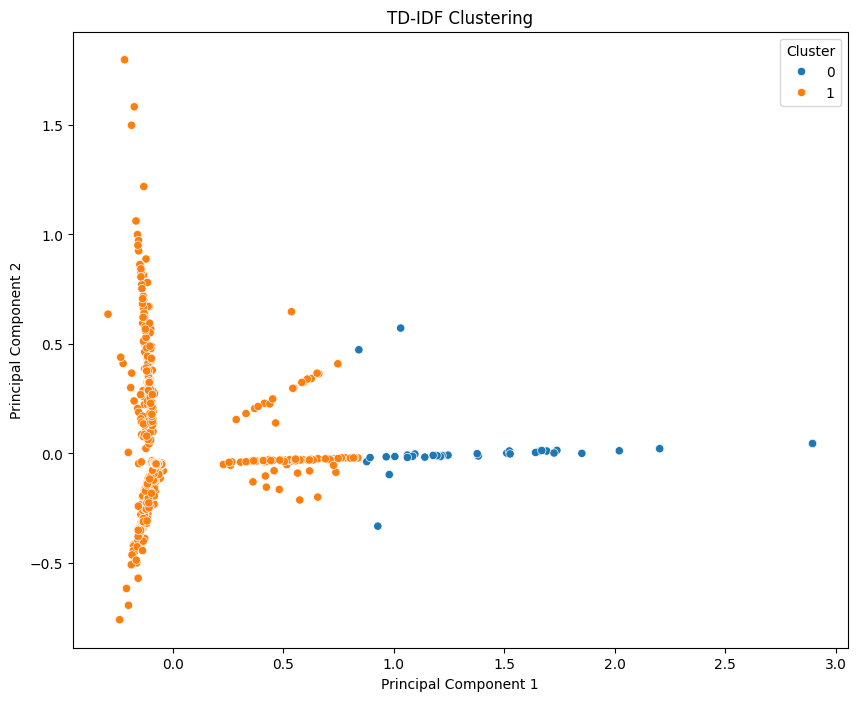

In [280]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_X_idf[:, 0], y=reduced_X_idf[:, 1], hue=reviews['tfidf_cluster'], palette='tab10')
plt.title('TD-IDF Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [244]:
#calculate what percentage of negative reviews ended up in what cluster
negative_reviews = reviews[reviews['polarity'] == "negative"]
print("Negative polarity cluster distribution of", negative_reviews['tfidf_cluster'].value_counts(normalize=True))

#calculate what percentage of positive reviews ended up in what cluster
positive_reviews = reviews[reviews['polarity'] == "positive"]
print("\nPositive polarity cluster distribution of", positive_reviews['tfidf_cluster'].value_counts(normalize=True))

Negative polarity cluster distribution of tfidf_cluster
1    1.0
Name: proportion, dtype: float64

Positive polarity cluster distribution of tfidf_cluster
1    0.963336
0    0.036664
Name: proportion, dtype: float64


##### Part II.2 BERT-uncased model

In [245]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset

In [246]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
tokenizer_un = BertTokenizer.from_pretrained('bert-base-uncased')
model_un = BertModel.from_pretrained('bert-base-uncased').to(device)
model_un.eval()  # Set the model to evaluation mode

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [247]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer_un(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

def get_embeddings(batch):
    # Move batch to the same device as model
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_un(**batch)
    embeddings = outputs.last_hidden_state[:,0,:].cpu().numpy()  # Get [CLS] token embeddings and move back to cpu
    return embeddings

In [248]:
# Create a dataset and dataloader
dataset_un = TextDataset(reviews['review'].tolist())
dataloader_un = DataLoader(dataset_un, batch_size=32)  # Adjust batch size based on your GPU/CPU memory

In [249]:
# # # Process in batches
# embeddings_un = []
# for batch in dataloader_un:
#     embeddings_un.extend(get_embeddings(batch))

In [250]:
# reviews['uncased_embedding'] = embeddings_un
# # convert the embeddings to lists of float64
# reviews['uncased_embedding'] = reviews['uncased_embedding'].apply(lambda x: x.tolist())

Here, I import the word embedding vectors that I saved in a csv to complete the clustering algorithm.

In [251]:
import ast

reviews["uncased_embedding"] = reviews_em["uncased_embedding"]
#convert the string to a list
reviews["uncased_embedding"] = reviews["uncased_embedding"].apply(lambda x: ast.literal_eval(x))

reviews.head()

,review,polarity,category,tfidf_cluster,uncased_embedding
0,long wanted visit came away somewhat disappointed,negative,RESTAURANT#GENERAL,1,"[-0.07776430249214172, 0.008164145052433014, 0..."
1,positives location general service one exception,positive,LOCATION#GENERAL,1,"[-0.3991141617298126, -0.08209023624658585, -0..."
2,directly overlooking thames would magical loca...,positive,LOCATION#GENERAL,1,"[-0.06357653439044952, 0.08461012691259384, 0...."
3,good location national theatre meters walk alo...,positive,LOCATION#GENERAL,1,"[-0.2133108675479889, -0.22457197308540344, -0..."
4,less positive,negative,FOOD#QUALITY,1,"[-0.4199187457561493, 0.07702987641096115, -0...."


In [252]:
k = 2
# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

X_unc = np.stack(reviews['uncased_embedding'].values)
pca = PCA(n_components=50)
reduced_X_unc = pca.fit_transform(X_unc)

In [253]:
# Fit KMeans to the dataset
kmeans.fit(reduced_X_unc)

# Adding cluster labels to reviews DataFrame
reviews['uncased_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [254]:
sil_score = silhouette_score(reduced_X_unc, kmeans.labels_)

print("Silhouette Score:", sil_score)

Silhouette Score: 0.17197296207970114


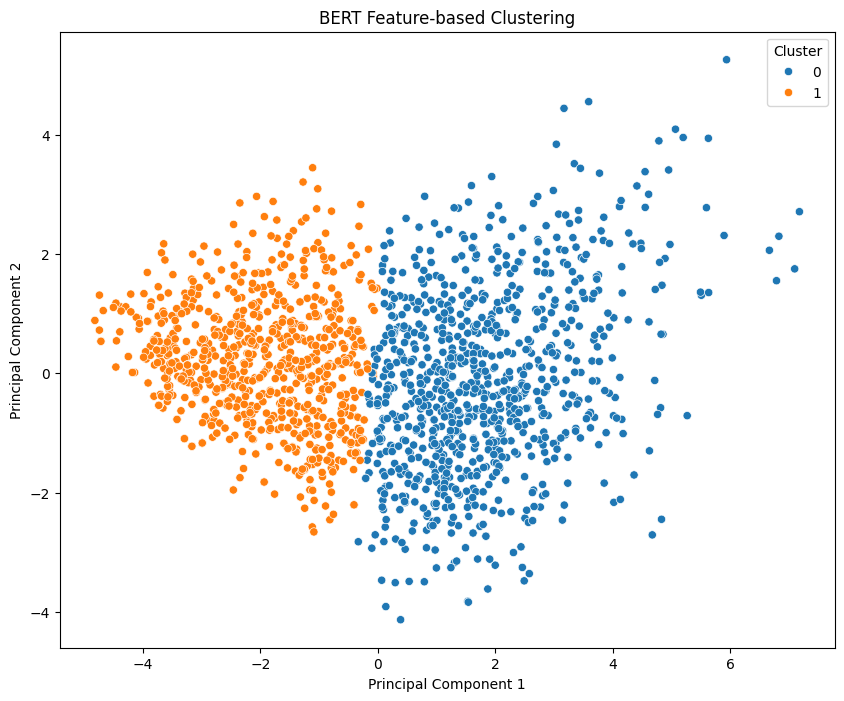

In [255]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_unc = pca.fit_transform(reduced_X_unc)
X_graph_unc.shape

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_unc[:, 0], y=X_graph_unc[:, 1], hue=reviews['uncased_cluster'], palette='tab10')
plt.title('BERT Feature-based Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [256]:
# Get the top 10 words for each cluster
top_words = []
for i in range(k):
    cluster_words = reviews[reviews['uncased_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')

Cluster 0: [('good', 188), ('service', 153), ('great', 121), ('excellent', 88), ('staff', 82), ('place', 63), ('wine', 61), ('always', 60), ('menu', 57), ('atmosphere', 56)]
Cluster 1: [('good', 95), ('great', 76), ('service', 75), ('excellent', 62), ('place', 46), ('would', 34), ('lovely', 34), ('staff', 33), ('always', 32), ('lunch', 31)]


In [257]:
#calculate what percentage of negative reviews ended up in what cluster
negative_reviews = reviews[reviews['polarity'] == "negative"]
print("Negative polarity cluster distribution of", negative_reviews['uncased_cluster'].value_counts(normalize=True))

#calculate what percentage of positive reviews ended up in what cluster
positive_reviews = reviews[reviews['polarity'] == "positive"]
print("\nPositive polarity cluster distribution of", positive_reviews['uncased_cluster'].value_counts(normalize=True))

Negative polarity cluster distribution of uncased_cluster
0    0.52518
1    0.47482
Name: proportion, dtype: float64

Positive polarity cluster distribution of uncased_cluster
0    0.531991
1    0.468009
Name: proportion, dtype: float64


##### Part II.3 BERT fine tuned model on polarity

In [258]:
model_ft = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [259]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [260]:
# encode the labels of polarity
reviews['polarity'] = reviews['polarity'].map({'positive': 1, 'negative': 0})
reviews['polarity'] = reviews['polarity'].astype(int)
reviews = reviews.reset_index(drop=True)
reviews.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster
0,long wanted visit came away somewhat disappointed,0,RESTAURANT#GENERAL,1,"[-0.07776430249214172, 0.008164145052433014, 0...",1
1,positives location general service one exception,1,LOCATION#GENERAL,1,"[-0.3991141617298126, -0.08209023624658585, -0...",0
2,directly overlooking thames would magical loca...,1,LOCATION#GENERAL,1,"[-0.06357653439044952, 0.08461012691259384, 0....",1
3,good location national theatre meters walk alo...,1,LOCATION#GENERAL,1,"[-0.2133108675479889, -0.22457197308540344, -0...",0
4,less positive,0,FOOD#QUALITY,1,"[-0.4199187457561493, 0.07702987641096115, -0....",1


In [261]:
dataset = ReviewsDataset(reviews["review"], reviews["polarity"], tokenizer_un, max_length=128)

In [262]:
#Create DataLoader
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [263]:
#Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_ft.to(device)
optimizer = AdamW(model_ft.parameters(), lr=2e-5)
total_steps = len(loader) * 3  # epochs need to be defined

# Scheduler for learning rate decay
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [264]:
# Training loop
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        correct_predictions += torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

In [265]:
# # Running training
# for epoch in range(3):
#     print(f'Epoch {epoch + 1}/{3}')
#     train_acc, train_loss = train_epoch(model, loader, optimizer, device, scheduler)
#     print(f'Train loss {train_loss}, accuracy {train_acc}')

In [266]:
def extract_embeddings(model, data_loader, device):
    model.eval()  # Put model in evaluation mode
    embeddings = []
    
    with torch.no_grad():  # Turn off gradients to save memory and computations
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Request the model to return hidden states
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
            
            # Extract the last hidden state
            hidden_states = outputs.hidden_states[-1]  # Get the last layer's hidden states
            # Use the mean of the hidden states as the document representation
            mean_embeddings = torch.mean(hidden_states, dim=1)  # shape: (batch_size, hidden_size)
            embeddings.append(mean_embeddings.cpu())
    
    embeddings = torch.cat(embeddings, dim=0)  # Concatenate embeddings from all batches
    return embeddings

In [267]:
# # Now call the function with your DataLoader
# embeddings_ft = extract_embeddings(model, loader, device)

In [268]:
# # add embeddings to the reviews df
# reviews['ft_embedding'] = embeddings_ft.tolist()

In [269]:
# # export the reviews df to a csv file
# reviews.to_csv('reviews_with_embeddings.csv', index=False, float_format='%.18g')

Here, I use the fine-tuning word embeddings from my pre-saved csv to run the clustering algorighm.

In [270]:
reviews["ft_embedding"] = reviews_em["ft_embedding"]
reviews.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster,ft_embedding
0,long wanted visit came away somewhat disappointed,0,RESTAURANT#GENERAL,1,"[-0.07776430249214172, 0.008164145052433014, 0...",1,"[0.2698621153831482, -0.06746410578489304, 0.2..."
1,positives location general service one exception,1,LOCATION#GENERAL,1,"[-0.3991141617298126, -0.08209023624658585, -0...",0,"[-0.1683657169342041, -0.2121722400188446, 0.5..."
2,directly overlooking thames would magical loca...,1,LOCATION#GENERAL,1,"[-0.06357653439044952, 0.08461012691259384, 0....",1,"[-0.3328630328178406, -0.4269963800907135, 0.7..."
3,good location national theatre meters walk alo...,1,LOCATION#GENERAL,1,"[-0.2133108675479889, -0.22457197308540344, -0...",0,"[0.18653923273086548, -0.24748297035694122, 0...."
4,less positive,0,FOOD#QUALITY,1,"[-0.4199187457561493, 0.07702987641096115, -0....",1,"[-0.14482760429382324, 0.4146779179573059, 0.3..."


In [271]:
# Convert string representations of lists to numpy arrays
reviews['ft_embedding'] = reviews['ft_embedding'].apply(lambda x: np.array(ast.literal_eval(x)))
reviews.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster,ft_embedding
0,long wanted visit came away somewhat disappointed,0,RESTAURANT#GENERAL,1,"[-0.07776430249214172, 0.008164145052433014, 0...",1,"[0.2698621153831482, -0.06746410578489304, 0.2..."
1,positives location general service one exception,1,LOCATION#GENERAL,1,"[-0.3991141617298126, -0.08209023624658585, -0...",0,"[-0.1683657169342041, -0.2121722400188446, 0.5..."
2,directly overlooking thames would magical loca...,1,LOCATION#GENERAL,1,"[-0.06357653439044952, 0.08461012691259384, 0....",1,"[-0.3328630328178406, -0.4269963800907135, 0.7..."
3,good location national theatre meters walk alo...,1,LOCATION#GENERAL,1,"[-0.2133108675479889, -0.22457197308540344, -0...",0,"[0.18653923273086548, -0.24748297035694122, 0...."
4,less positive,0,FOOD#QUALITY,1,"[-0.4199187457561493, 0.07702987641096115, -0....",1,"[-0.14482760429382324, 0.4146779179573059, 0.3..."


In [272]:
k = 2
# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

X_ft = np.stack(reviews['ft_embedding'].values)
pca = PCA(n_components=50)
reduced_X_ft = pca.fit_transform(X_ft)

In [273]:
# Fit KMeans to the dataset
kmeans.fit(reduced_X_ft)

# Adding cluster labels to reviews DataFrame
reviews['ft_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [274]:
sil_score = silhouette_score(reduced_X_ft, kmeans.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.5334555485590762


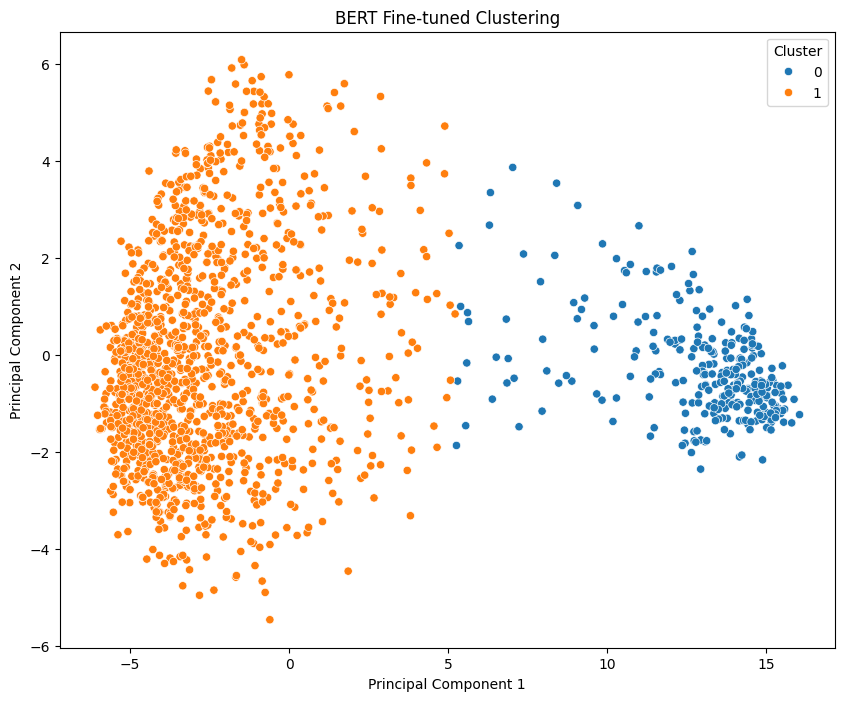

Cluster 0: [('good', 61), ('service', 37), ('great', 37), ('excellent', 26), ('staff', 18), ('place', 18), ('lovely', 17), ('table', 17), ('menu', 16), ('always', 16)]
Cluster 1: [('good', 222), ('service', 191), ('great', 160), ('excellent', 124), ('staff', 97), ('place', 91), ('always', 76), ('london', 69), ('atmosphere', 67), ('one', 59)]


In [276]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_ft = pca.fit_transform(reduced_X_ft)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_ft[:, 0], y=X_graph_ft[:, 1], hue=reviews['ft_cluster'], palette='tab10')
plt.title('BERT Fine-tuned Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Get the top 10 words for each cluster
top_words = []
for i in range(k):
    cluster_words = reviews[reviews['ft_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')


In [160]:
#calculate what percentage of negative reviews ended up in what cluster
negative_reviews = reviews[reviews['polarity'] == 0]
print("Negative polarity cluster distribution of", negative_reviews['ft_cluster'].value_counts(normalize=True))

#calculate what percentage of positive reviews ended up in what cluster
positive_reviews = reviews[reviews['polarity'] == 1]
print("\nPositive polarity cluster distribution of", positive_reviews['ft_cluster'].value_counts(normalize=True))

Negative polarity cluster distribution of ft_cluster
1    0.866906
0    0.133094
Name: proportion, dtype: float64

Positive polarity cluster distribution of ft_cluster
1    0.818116
0    0.181884
Name: proportion, dtype: float64


#### Part III: Coreset Algorithm with different partitions using BERT fine-tuned word embedding

##### Part III.1 Random partition

In [198]:
#implement coreset algorithm
#randomly divide reviews into 6 groups
np.random.seed(0)
reviews['random_group'] = np.random.randint(0, 6, reviews.shape[0])
reviews.shape[0]

1669

In [201]:
coreset_rand = pd.DataFrame()

# sample 20% of each group
for i in range(6):
    sample = reviews[reviews['random_group'] == i].sample(frac=0.2)
    coreset_rand = pd.concat([coreset_rand, sample], ignore_index=True)

coreset_rand = coreset_rand.reset_index(drop=True)

In [202]:
X_rand = np.stack(coreset_rand['ft_embedding'].values)
pca = PCA(n_components=50)

reduced_X_rand = pca.fit_transform(X_rand)

In [203]:
k = 2

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit KMeans to the dataset
kmeans.fit(reduced_X_rand)

coreset_rand['ft_rand_cluster'] = kmeans.labels_
coreset_rand.head()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster,ft_embedding,ft_cluster,random_group,main_category,ft_rand_cluster
0,looking somewhere eat great atmosphere lots hu...,1,AMBIENCE#GENERAL,1,"[-0.005607777740806341, 0.12514668703079224, 0...",0,"[0.10255713760852814, 0.2767285108566284, 0.78...",1,0,AMBIENCE,0
1,truly superb lunch,1,FOOD#QUALITY,1,"[-0.1321324110031128, 0.01639385148882866, 3.0...",1,"[0.38472411036491394, -0.20019643008708954, 0....",1,0,FOOD,0
2,whether want pay hefty premium eat,0,RESTAURANT#PRICES,1,"[-0.15661875903606415, 0.1936708390712738, 0.1...",0,"[-0.021539639681577682, -0.027185307815670967,...",1,0,RESTAURANT,0
3,ive many times never bad experience,1,RESTAURANT#GENERAL,1,"[-0.2139114886522293, 0.43932247161865234, -0....",0,"[-0.07424598932266235, -0.30642223358154297, 0...",1,0,RESTAURANT,0
4,come back give another opportunity deserve itr...,1,RESTAURANT#GENERAL,1,"[-0.30785781145095825, 0.35849618911743164, -0...",0,"[0.04303419962525368, 0.031382348388433456, 0....",1,0,RESTAURANT,0


In [204]:
sil_score = silhouette_score(reduced_X_rand, kmeans.labels_)

print("Silhouette Score:", sil_score)


Silhouette Score: 0.5223437852591101


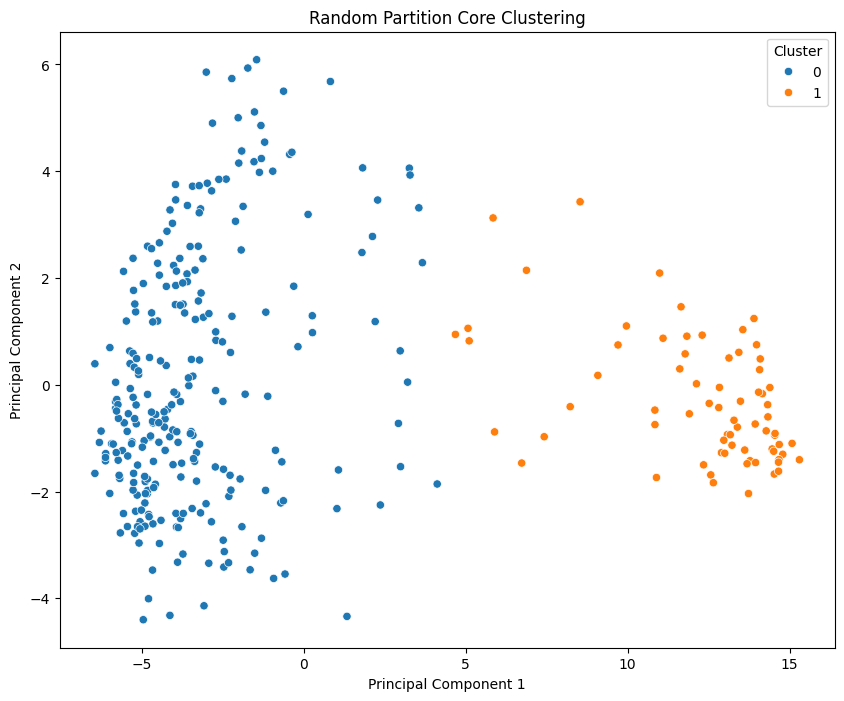

Cluster 0: [('good', 53), ('service', 43), ('excellent', 28), ('great', 25), ('place', 19), ('staff', 18), ('always', 13), ('lovely', 13), ('experience', 12), ('time', 12)]
Cluster 1: [('good', 18), ('great', 9), ('service', 8), ('excellent', 6), ('table', 6), ('water', 5), ('lunch', 5), ('wine', 4), ('love', 4), ('every', 4)]


In [277]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_rand = pca.fit_transform(reduced_X_rand)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_rand[:, 0], y=X_graph_rand[:, 1], hue=coreset_rand['ft_rand_cluster'], palette='tab10')
plt.title('Random Partition Core Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Get the top 10 words for each cluster
top_words = []
for i in range(k):
    cluster_words = coreset_rand[coreset_rand['ft_rand_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')


In [206]:
#calculate what percentage of negative reviews ended up in what cluster
negative_reviews_core = coreset_rand[coreset_rand['polarity'] == 0]

print("Negative polarity cluster distribution of ", negative_reviews_core['ft_rand_cluster'].value_counts(normalize=True))

positive_reviews_core = coreset_rand[coreset_rand['polarity'] == 1]

print("Positive polarity cluster distribution of ",positive_reviews_core['ft_rand_cluster'].value_counts(normalize=True))

Negative polarity cluster distribution of  ft_rand_cluster
0    0.816327
1    0.183673
Name: proportion, dtype: float64
Positive polarity cluster distribution of  ft_rand_cluster
0    0.778169
1    0.221831
Name: proportion, dtype: float64


##### Part III.2 Category partition

In [175]:
# get the categories
reviews["category"].value_counts()

category
RESTAURANT#GENERAL          455
FOOD#QUALITY                413
SERVICE#GENERAL             281
AMBIENCE#GENERAL            203
FOOD#STYLE_OPTIONS           77
LOCATION#GENERAL             70
RESTAURANT#PRICES            46
DRINKS#QUALITY               43
RESTAURANT#MISCELLANEOUS     36
FOOD#PRICES                  19
DRINKS#STYLE_OPTIONS         16
DRINKS#PRICES                10
Name: count, dtype: int64

There are a combination of 12 categories, but there are 6 wide categories: restaurant, food, service, ambience, location, drinks. I will keep the six large categories for partition. The categories have uneven numbers, so I will take a proportion of samples rather than a set number.

In [176]:
reviews['main_category'] = reviews['category'].str.split('#').str[0]
reviews["main_category"].value_counts()

main_category
RESTAURANT    537
FOOD          509
SERVICE       281
AMBIENCE      203
LOCATION       70
DRINKS         69
Name: count, dtype: int64

In [177]:
#randomly select half of the reviews from each category
coreset_cat = pd.DataFrame()
for cat in reviews["main_category"].unique():
    category_subset = reviews[reviews['main_category'] == cat]
    n_samples = len(category_subset) // 2
    
    sampled_data = category_subset.sample(n_samples)
    coreset_cat = pd.concat([coreset_cat, sampled_data])

coreset_cat.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster,ft_embedding,ft_cluster,random_group,main_category
1184,lovely place,1,RESTAURANT#GENERAL,1,"[-0.0008021569810807705, 0.12225440889596939, ...",1,"[-0.25142520666122437, -0.20315127074718475, 0...",1,0,RESTAURANT
1216,lovely lunch two occasions would definitely re...,1,RESTAURANT#GENERAL,1,"[0.03837207332253456, 0.0023687630891799927, 0...",1,"[-0.026523839682340622, -0.10059884190559387, ...",1,3,RESTAURANT
13,enjoyable,1,RESTAURANT#GENERAL,1,"[-0.22872459888458252, 0.1891036331653595, -0....",1,"[0.2015855312347412, -0.12737196683883667, 0.0...",1,4,RESTAURANT
1523,ive going since,1,RESTAURANT#GENERAL,1,"[0.04093701392412186, 0.3948308229446411, -0.1...",0,"[0.10463922470808029, -0.04137168824672699, 0....",1,5,RESTAURANT
255,good nice view worth money,1,RESTAURANT#PRICES,1,"[-0.052276015281677246, 0.062481075525283813, ...",0,"[0.25614264607429504, -0.15521936118602753, 0....",1,5,RESTAURANT


In [178]:
X_core_cat = np.stack(coreset_cat['ft_embedding'].values)

pca = PCA(n_components=50)
reduced_X_core_cat = pca.fit_transform(X_core_cat)

In [179]:
k = 2

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit KMeans to the dataset
kmeans.fit(reduced_X_core_cat)

coreset_cat['cat_core_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [180]:
sil_score = silhouette_score(reduced_X_core_cat, kmeans.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.5225144119825159


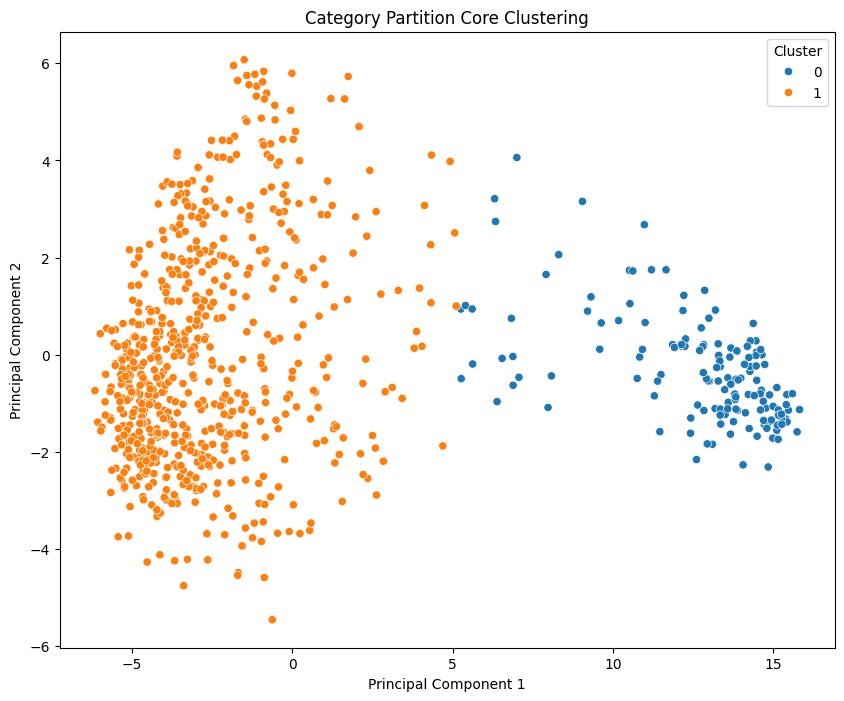

Cluster 0: [('good', 28), ('great', 18), ('service', 17), ('excellent', 12), ('lovely', 11), ('staff', 10), ('place', 9), ('menu', 9), ('one', 8), ('love', 7)]
Cluster 1: [('good', 102), ('service', 89), ('great', 83), ('excellent', 50), ('staff', 43), ('always', 40), ('place', 36), ('wine', 33), ('atmosphere', 32), ('one', 29)]


In [278]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_core_cat = pca.fit_transform(reduced_X_core_cat)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_core_cat[:, 0], y=X_graph_core_cat[:, 1], hue=coreset_cat['cat_core_cluster'], palette='tab10')
plt.title('Category Partition Core Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Get the top 10 words for each cluster
top_words = []
for i in range(k):
    cluster_words = coreset_cat[coreset_cat['cat_core_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')


In [196]:
#calculate what percentage of negative reviews ended up in what cluster
negative_reviews_core = coreset_cat[coreset_cat['polarity'] == 0]

print("Negative polarity cluster distribution of ", negative_reviews_core['cat_core_cluster'].value_counts(normalize=True))

positive_reviews_core = coreset_cat[coreset_cat['polarity'] == 1]

print("Positive polarity cluster distribution of ",positive_reviews_core['cat_core_cluster'].value_counts(normalize=True))

Negative polarity cluster distribution of  cat_core_cluster
1    0.836879
0    0.163121
Name: proportion, dtype: float64
Positive polarity cluster distribution of  cat_core_cluster
1    0.82055
0    0.17945
Name: proportion, dtype: float64


##### Part III.3 Polarity partition

In [182]:
# Randomly select half of the reviews from each polarity

coreset_pol = pd.DataFrame()
for pol in reviews["polarity"].unique():
    polarity_subset = reviews[reviews['polarity'] == pol]
    n_samples = len(polarity_subset) // 4
    
    sampled_data = polarity_subset.sample(n_samples)
    coreset_pol = pd.concat([coreset_pol, sampled_data])

coreset_pol.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster,ft_embedding,ft_cluster,random_group,main_category
176,good service rushed,0,SERVICE#GENERAL,1,"[-0.011867334134876728, 0.24095696210861206, -...",1,"[0.010688929818570614, 0.16909338533878326, 0....",1,5,SERVICE
1650,seems doubtful experience due freshness could ...,0,FOOD#QUALITY,1,"[-0.15619008243083954, -0.07608753442764282, 0...",0,"[0.26414695382118225, -0.24564552307128906, 0....",1,0,FOOD
169,feels little kind retro probably hasnt kept pa...,0,AMBIENCE#GENERAL,1,"[0.022518444806337357, 0.3004687428474426, 0.1...",0,"[0.1343783140182495, -0.009359750896692276, 0....",1,5,AMBIENCE
620,neither burgers saw somewhat disappointed,0,FOOD#QUALITY,1,"[0.01946958154439926, 0.13407912850379944, 0.1...",1,"[0.184853196144104, -0.027464818209409714, 0.8...",1,0,FOOD
22,however onion compote like vile spoiled dish,0,FOOD#QUALITY,1,"[-0.3106839060783386, 0.12142729014158249, -0....",0,"[0.22599445283412933, -0.15501296520233154, 0....",1,1,FOOD


In [183]:
X_core_pol = np.stack(coreset_pol['ft_embedding'].values)

pca = PCA(n_components=50)
reduced_X_core_pol = pca.fit_transform(X_core_pol)

In [184]:
k = 2

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit KMeans to the dataset
kmeans.fit(reduced_X_core_pol)

coreset_pol['pol_core_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [185]:
sil_score = silhouette_score(reduced_X_core_pol, kmeans.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.5388265346880562


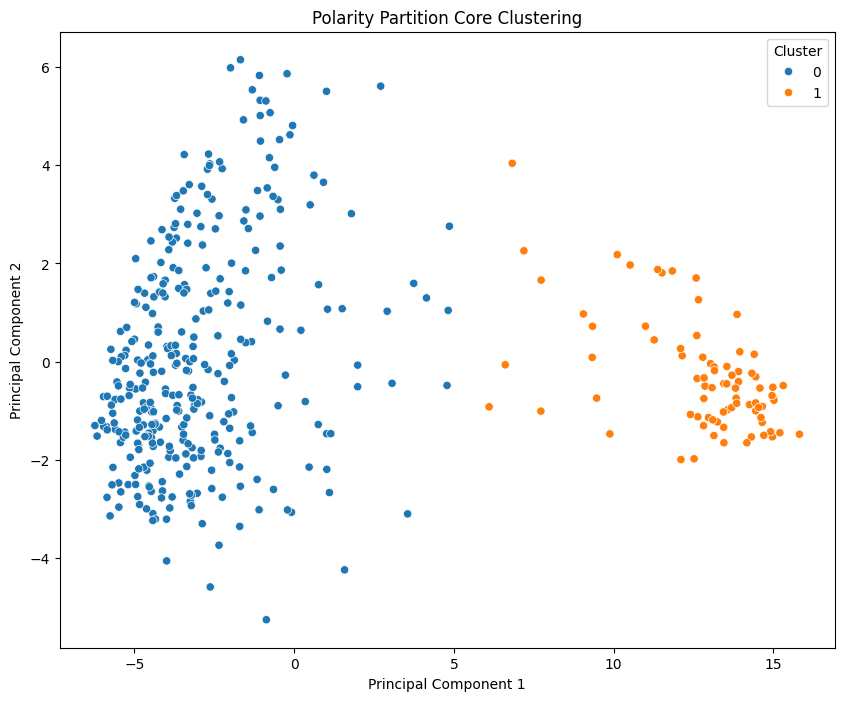

Cluster 0: [('good', 55), ('great', 46), ('service', 45), ('excellent', 34), ('place', 21), ('staff', 19), ('always', 18), ('atmosphere', 18), ('table', 17), ('really', 16)]
Cluster 1: [('service', 16), ('good', 16), ('great', 11), ('excellent', 10), ('place', 9), ('well', 6), ('menu', 6), ('atmosphere', 5), ('best', 5), ('wine', 5)]


In [279]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_core_pol = pca.fit_transform(reduced_X_core_pol)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_core_pol[:, 0], y=X_graph_core_pol[:, 1], hue=coreset_pol['pol_core_cluster'], palette='tab10')
plt.title('Polarity Partition Core Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Get the top 10 words for each cluster
top_words = []
for i in range(k):
    cluster_words = coreset_pol[coreset_pol['pol_core_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')

In [197]:
#calculate what percentage of negative reviews ended up in what cluster
negative_reviews_core = coreset_pol[coreset_pol['polarity'] == 0]

print("Negative polarity cluster distribution of ", negative_reviews_core['pol_core_cluster'].value_counts(normalize=True))

positive_reviews_core = coreset_pol[coreset_pol['polarity'] == 1]

print("Positive polarity cluster distribution of ",positive_reviews_core['pol_core_cluster'].value_counts(normalize=True))

Negative polarity cluster distribution of  pol_core_cluster
0    0.884058
1    0.115942
Name: proportion, dtype: float64
Positive polarity cluster distribution of  pol_core_cluster
0    0.792507
1    0.207493
Name: proportion, dtype: float64


#### Part IV: Further experimentation

Here are two things to try:

1. more clusters to see if the model does better.

2. recursive clustering on cluster one to see if the model does differently.

##### Part IV.1 K = 10 K-means

In [211]:
fur_exp = pd.DataFrame()
fur_exp["review"] = reviews["review"]
fur_exp["polarity"] = reviews["polarity"]
fur_exp["ft_embedding"] = reviews["ft_embedding"]

fur_exp.head()

,review,polarity,ft_embedding
0,long wanted visit came away somewhat disappointed,0,"[0.2698621153831482, -0.06746410578489304, 0.2..."
1,positives location general service one exception,1,"[-0.1683657169342041, -0.2121722400188446, 0.5..."
2,directly overlooking thames would magical loca...,1,"[-0.3328630328178406, -0.4269963800907135, 0.7..."
3,good location national theatre meters walk alo...,1,"[0.18653923273086548, -0.24748297035694122, 0...."
4,less positive,0,"[-0.14482760429382324, 0.4146779179573059, 0.3..."


In [212]:
k = 10
# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

X_fur = np.stack(fur_exp['ft_embedding'].values)

pca = PCA(n_components=50)

reduced_X_fur = pca.fit_transform(X_fur)

# Fit KMeans to the dataset

kmeans.fit(reduced_X_fur)

fur_exp['ft_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [214]:
sil_score = silhouette_score(reduced_X_fur, kmeans.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.11014014490535098


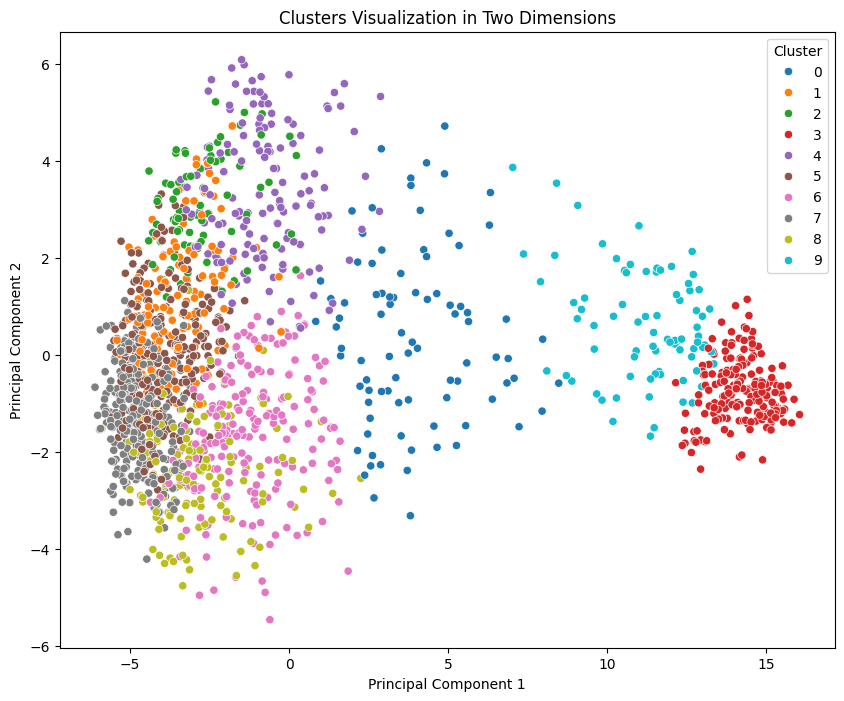

In [216]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_fur = pca.fit_transform(reduced_X_fur)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_fur[:, 0], y=X_graph_fur[:, 1], hue=fur_exp['ft_cluster'], palette='tab10')
plt.title('Clusters Visualization in Two Dimensions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [215]:
# random partition
fur_exp['random_group'] = np.random.randint(0, 6, fur_exp.shape[0])

coreset_rand_fur = pd.DataFrame()

# sample 20% of each group

for i in range(6):
    sample = fur_exp[fur_exp['random_group'] == i].sample(frac=0.2)
    coreset_rand_fur = pd.concat([coreset_rand_fur, sample], ignore_index=True)

coreset_rand_fur = coreset_rand_fur.reset_index(drop=True)


In [217]:
k = 10

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

X_rand_fur = np.stack(coreset_rand_fur['ft_embedding'].values)

pca = PCA(n_components=50)

reduced_X_rand_fur = pca.fit_transform(X_rand_fur)

# Fit KMeans to the dataset
kmeans.fit(reduced_X_rand_fur)

coreset_rand_fur['ft_rand_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [218]:
sil_score = silhouette_score(reduced_X_rand_fur, kmeans.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.10099793522727908


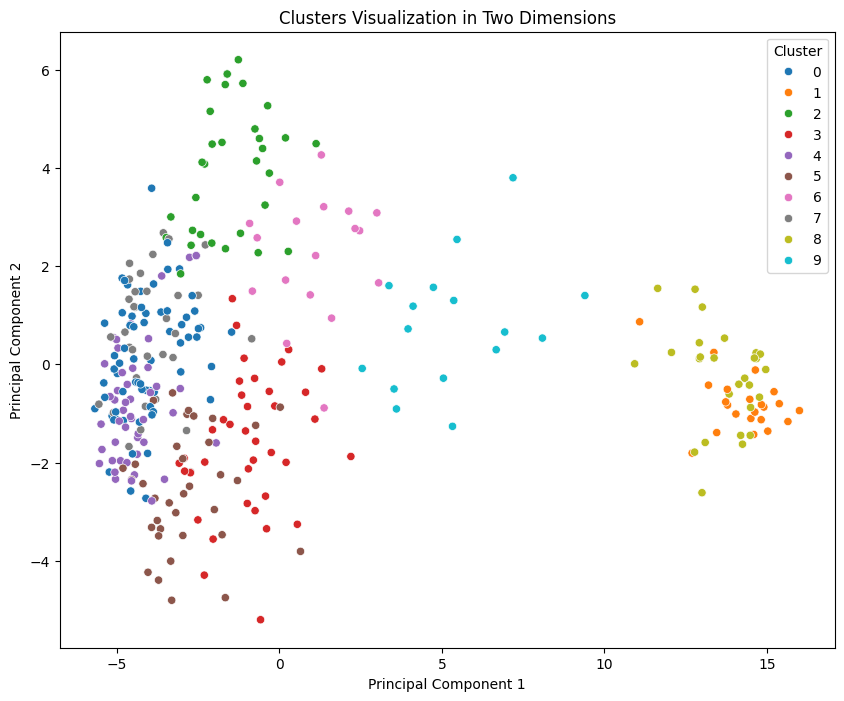

In [219]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_rand_fur = pca.fit_transform(reduced_X_rand_fur)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_rand_fur[:, 0], y=X_graph_rand_fur[:, 1], hue=coreset_rand_fur['ft_rand_cluster'], palette='tab10')
plt.title('Clusters Visualization in Two Dimensions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

##### Part IV.2 Recursive clustering on cluster 1 of BERT fine-tuned clustering

In [282]:
recu_clu = pd.DataFrame()
# get the review rows where ft_cluster is 0

recu_clu = reviews[reviews['ft_cluster'] == 0]
recu_clu.head()

,review,polarity,category,tfidf_cluster,uncased_embedding,uncased_cluster,ft_embedding,ft_cluster
2,directly overlooking thames would magical loca...,1,LOCATION#GENERAL,1,"[-0.06357653439044952, 0.08461012691259384, 0....",1,"[-0.3328630328178406, -0.4269963800907135, 0.7...",0
5,really good langoustine starter,1,FOOD#QUALITY,1,"[-0.29048028588294983, 0.013507287949323654, -...",1,"[-0.32188934087753296, -0.056842539459466934, ...",0
9,negative,0,RESTAURANT#GENERAL,1,"[-0.23555290699005127, 0.17621085047721863, -0...",1,"[-0.34953802824020386, 0.38708338141441345, 0....",0
11,certainly clouded overall experience,0,RESTAURANT#GENERAL,1,"[-0.11876680701971054, 0.23721826076507568, -0...",1,"[-0.12536932528018951, 0.06856489181518555, 0....",0
29,impressed,1,RESTAURANT#GENERAL,1,"[-0.1591780185699463, 0.2007080614566803, 0.09...",1,"[-0.114688441157341, 0.028500037267804146, 0.2...",0


In [290]:
k = 2

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=0)

X_recu = np.stack(recu_clu['ft_embedding'].values)

pca = PCA(n_components=50)

reduced_X_recu = pca.fit_transform(X_recu)

# Fit KMeans to the dataset
kmeans.fit(reduced_X_recu)

recu_clu['ft_recu_cluster'] = kmeans.labels_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/35/9crwbggj0ld8mjg01rwhl37c0000gn/T/ipykernel_88321/145469080.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recu_clu['ft_recu_cluster'] = kmeans.labels_


In [291]:
sil_score = silhouette_score(reduced_X_recu, kmeans.labels_)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.2529466039047315


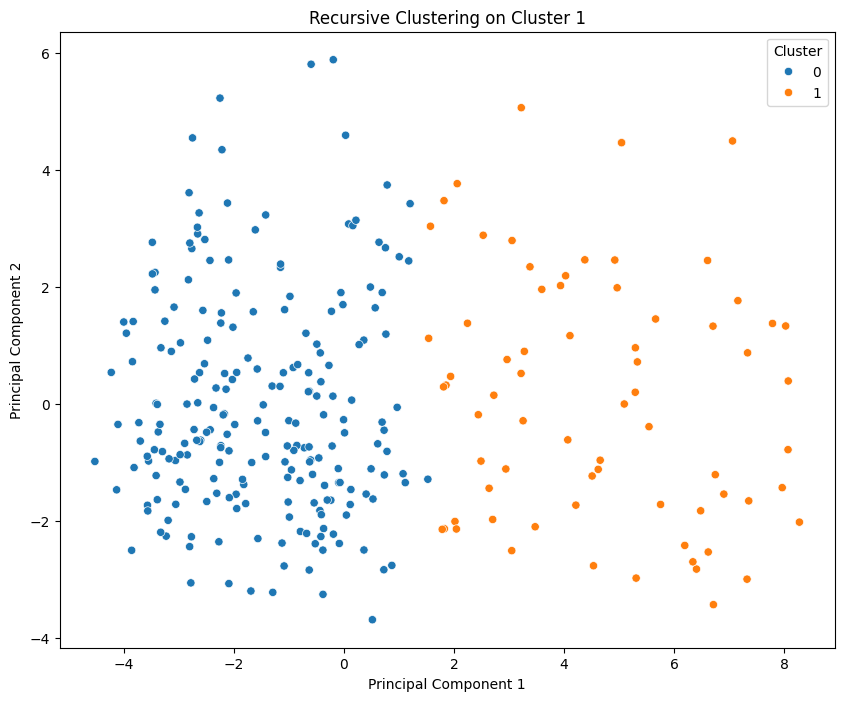

In [292]:
pca = PCA(n_components=2)  # Reduce to two dimensions for visualization
X_graph_recu = pca.fit_transform(reduced_X_recu)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_graph_recu[:, 0], y=X_graph_recu[:, 1], hue=recu_clu['ft_recu_cluster'], palette='tab10')
plt.title('Recursive Clustering on Cluster 1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [293]:
# get top words
top_words = []
for i in range(k):
    cluster_words = recu_clu[recu_clu['ft_recu_cluster'] == i]['review'].apply(lambda x: x.split()).sum()
    top_words.append(Counter(cluster_words).most_common(10))

for i, words in enumerate(top_words):
    print(f'Cluster {i}: {words}')


Cluster 0: [('good', 48), ('service', 28), ('great', 26), ('excellent', 22), ('staff', 16), ('lovely', 14), ('table', 13), ('one', 12), ('always', 12), ('wine', 11)]
Cluster 1: [('good', 13), ('great', 11), ('service', 9), ('place', 7), ('menu', 6), ('dinner', 5), ('back', 4), ('table', 4), ('meal', 4), ('excellent', 4)]
